# Chapter 6 - Linear Model Selection and Regularization

- [Lab 2: Ridge Regression](#6.6.1-Ridge-Regression)
- [Lab 2: The Lasso](#6.6.2-The-Lasso)
- [Lab 3: Principal Components Regression](#6.7.1-Principal-Components-Regression)
- [Lab 3: Partial Least Squares](#6.7.2-Partial-Least-Squares)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glmnet as gln
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import requests
import csv

%matplotlib inline
plt.style.use('seaborn-white')

/home/troysattgast/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/troysattgast/miniconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Lab 2

In [24]:
# read data function
def get_csv_df(url):
    with requests.Session() as s:
        download = s.get(url)
        decoded_content = download.content.decode('utf-8')
        cr = csv.reader(decoded_content.splitlines(), delimiter=',')
        return list(cr)

def standardize_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').\
      str.replace('(', '').str.replace(')', '')
    return df

In [35]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
hit_url = 'https://gist.githubusercontent.com/keeganhines/59974f1ebef97bbaa44fb19143f90bad/raw/d9bcf657f97201394a59fffd801c44347eb7e28d/Hitters.csv'
hit_data = get_csv_df(hit_url)
df = pd.DataFrame(hit_data[1:], columns=hit_data[0])
df.rename(columns={'':'player'}, inplace=True)
df.set_index('player', inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')
df.Salary = pd.to_numeric(df.Salary, errors='coerce')
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [36]:
df.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')

In [37]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [39]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0    

In [40]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    uint8  
 17  Division_W   263 non-null    uint8  
 18  NewLeague_N  263 non-null    uint8

In [41]:
X.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


In [42]:
# I executed the R code and downloaded the exact same training/test sets used in the book.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

### 6.6.1 Ridge Regression

### Scikit-learn

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:
### $$ \frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) $$
(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to
### $$ \frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 $$
The __sklearn Ridge()__ function optimizes:
### $$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
which is equivalent to optimizing
### $$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$

In [44]:
y

player
-Alan Ashby           475.0
-Alvin Davis          480.0
-Andre Dawson         500.0
-Andres Galarraga      91.5
-Alfredo Griffin      750.0
                      ...  
-Willie McGee         700.0
-Willie Randolph      875.0
-Wayne Tolleson       385.0
-Willie Upshaw        960.0
-Willie Wilson       1000.0
Name: Salary, Length: 263, dtype: float64

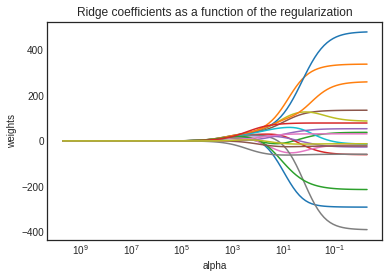

In [45]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

#### Alpha = 4

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

In [47]:
ridge2 = Ridge(alpha=len(X_)*11498/2)
ridge2.fit(scaler.transform(X_train), y_train)
pred = ridge2.predict(scaler.transform(X_test))
mean_squared_error(y_test, pred)

172760.95839299128

In [48]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat          0.016696
Hits           0.018680
HmRun          0.014374
Runs           0.017397
RBI            0.021043
Walks          0.019441
Years          0.016378
CAtBat         0.021240
CHits          0.022686
CHmRun         0.022709
CRuns          0.023280
CRBI           0.023814
CWalks         0.021261
PutOuts        0.018851
Assists       -0.000321
Errors         0.001149
League_N      -0.001080
Division_W    -0.006714
NewLeague_N   -0.000874
dtype: float64

#### Alpha = $10^{10}$ 
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [49]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

172862.2200557664

#### Compute the regularization path using RidgeCV

In [50]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+0...
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring='neg_mean_squared_error', store_cv_values=False)

In [51]:
ridgecv.alpha_

66.09705742330144

In [52]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))

101437.87891789111

In [53]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat          -5.266903
Hits           42.293974
HmRun          -4.414799
Runs           18.300973
RBI            35.122753
Walks          50.045214
Years           4.266424
CAtBat         13.869952
CHits          34.924052
CHmRun         47.437613
CRuns          35.565533
CRBI           47.132307
CWalks         23.839983
PutOuts        87.503814
Assists        -2.311463
Errors         -2.639522
League_N       10.060616
Division_W    -47.990988
NewLeague_N     4.726928
dtype: float64

### python-glmnet (update 2016-08-29)
This relatively new module is a wrapper for the fortran library used in the R package `glmnet`. It gives mostly the exact same results as described in the book. However, the `predict()` method does not give you the regression *coefficients* for lambda values not in the lambda_path. It only returns the predicted values.
https://github.com/civisanalytics/python-glmnet

In [54]:
grid = 10**np.linspace(10,-2,100)

ridge3 = gln.ElasticNet(alpha=0, lambda_path=grid)
ridge3.fit(X, y)

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.5793322...
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=3,
           random_state=None, scoring=None, standardize=True, tol=1e-07,
           upper_limits=inf, verbose=False)

#### Lambda 11498

In [55]:
ridge3.lambda_path_[49]

11497.569953977356

In [56]:
print('Intercept: {:.3f}'.format(ridge3.intercept_path_[49]))

Intercept: 407.356


In [57]:
pd.Series(np.round(ridge3.coef_path_[:,49], decimals=3), index=X.columns)

AtBat          0.037
Hits           0.138
HmRun          0.525
Runs           0.231
RBI            0.240
Walks          0.290
Years          1.108
CAtBat         0.003
CHits          0.012
CHmRun         0.088
CRuns          0.023
CRBI           0.024
CWalks         0.025
PutOuts        0.016
Assists        0.003
Errors        -0.021
League_N       0.085
Division_W    -6.215
NewLeague_N    0.301
dtype: float64

In [58]:
np.sqrt(np.sum(ridge3.coef_path_[:,49]**2))

6.3606122865384505

#### Lambda 705

In [59]:
ridge3.lambda_path_[59]

705.4802310718645

In [60]:
print('Intercept: {:.3f}'.format(ridge3.intercept_path_[59]))

Intercept: 54.325


In [61]:
pd.Series(np.round(ridge3.coef_path_[:,59], decimals=3), index=X.columns)

AtBat           0.112
Hits            0.656
HmRun           1.180
Runs            0.938
RBI             0.847
Walks           1.320
Years           2.596
CAtBat          0.011
CHits           0.047
CHmRun          0.338
CRuns           0.094
CRBI            0.098
CWalks          0.072
PutOuts         0.119
Assists         0.016
Errors         -0.704
League_N       13.684
Division_W    -54.659
NewLeague_N     8.612
dtype: float64

In [62]:
np.sqrt(np.sum(ridge3.coef_path_[:,59]**2))

57.11003436702412

#### Fit model using just the training set.

In [63]:
ridge4 = gln.ElasticNet(alpha=0, lambda_path=grid, scoring='mean_squared_error', tol=1e-12)
ridge4.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.5793322...
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=3,
           random_state=None, scoring='mean_squared_error', standardize=True,
           tol=1e-12, upper_limits=inf, verbose=False)

In [64]:
# prediction using lambda = 4
pred = ridge4.predict(X_test, lamb=4)
mean_squared_error(y_test.values.ravel(), pred)

103226.84322761731

#### Lambda chosen by cross validation

In [65]:
ridge5 = gln.ElasticNet(alpha=0, scoring='mean_squared_error')
ridge5.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True, lambda_path=None,
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=3,
           random_state=None, scoring='mean_squared_error', standardize=True,
           tol=1e-07, upper_limits=inf, verbose=False)

In [66]:
# Lambda with best CV performance
ridge5.lambda_max_

592.540275491641

In [67]:
# Lambda larger than lambda_max_, but with a CV score that is within 1 standard deviation away from lambda_max_ 
ridge5.lambda_best_

array([16875.75958093])

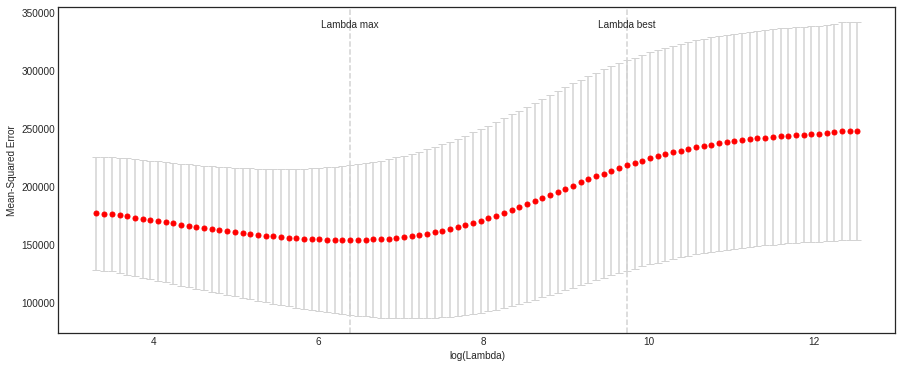

In [68]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(ridge5.lambda_path_), -ridge5.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=ridge5.cv_standard_error_, ecolor='lightgrey', capsize=4)

for ref, txt in zip([ridge5.lambda_best_, ridge5.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [69]:
# MSE for lambda with best CV performance
pred = ridge5.predict(X_test, lamb=ridge5.lambda_max_)
mean_squared_error(y_test, pred)

99714.77905926616

#### Fit model to full data set

In [70]:
ridge6= gln.ElasticNet(alpha=0, scoring='mean_squared_error', n_splits=10)
ridge6.fit(X, y)

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True, lambda_path=None,
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=10,
           random_state=None, scoring='mean_squared_error', standardize=True,
           tol=1e-07, upper_limits=inf, verbose=False)

In [71]:
# These are not really close to the ones in the book.
pd.Series(ridge6.coef_path_[:,ridge6.lambda_max_inx_], index=X.columns)

AtBat           -0.024196
Hits             1.160711
HmRun           -0.263126
Runs             1.143687
RBI              0.862877
Walks            1.966767
Years           -1.136127
CAtBat           0.010657
CHits            0.072265
CHmRun           0.492203
CRuns            0.143408
CRBI             0.152844
CWalks           0.000972
PutOuts          0.209667
Assists          0.056659
Errors          -2.194202
League_N        31.509818
Division_W    -100.399083
NewLeague_N      4.428319
dtype: float64

### 6.6.2 The Lasso

### Scikit-learn



For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
### $$ \lambda |\beta|_1 $$

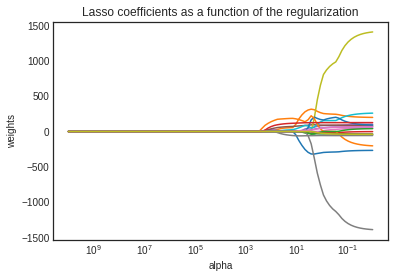

In [72]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [73]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.values.ravel())

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [74]:
lassocv.alpha_

27.503283261878394

In [75]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

106183.71692611944

In [76]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits            50.246197
HmRun            0.000000
Runs             0.000000
RBI              0.000000
Walks           66.794424
Years            0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun          19.441152
CRuns            0.000000
CRBI           181.336557
CWalks           0.000000
PutOuts        110.307327
Assists         -0.000000
Errors          -0.000000
League_N         0.000000
Division_W     -44.530872
NewLeague_N      0.000000
dtype: float64

### python-glmnet

In [77]:
lasso2 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error', n_splits=10)
lasso2.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=1, cut_point=1.0, fit_intercept=True,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.5793322...
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=10,
           random_state=None, scoring='mean_squared_error', standardize=True,
           tol=1e-07, upper_limits=inf, verbose=False)

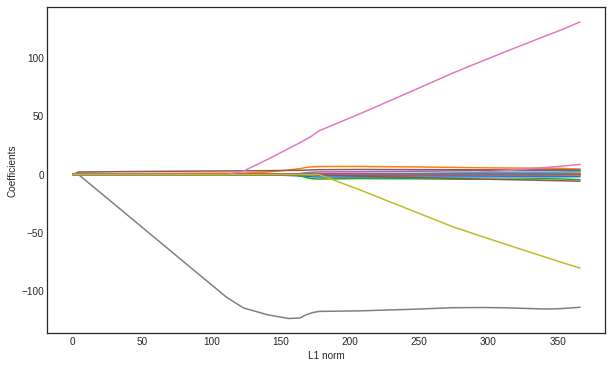

In [78]:
l1_norm = np.sum(np.abs(lasso2.coef_path_), axis=0)

plt.figure(figsize=(10,6))
plt.plot(l1_norm, lasso2.coef_path_.T)
plt.xlabel('L1 norm')
plt.ylabel('Coefficients');

#### Let glmnet() create a grid to use in CV

In [79]:
lasso3 = gln.ElasticNet(alpha=1, scoring='mean_squared_error', n_splits=10)
lasso3.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=1, cut_point=1.0, fit_intercept=True, lambda_path=None,
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=10,
           random_state=None, scoring='mean_squared_error', standardize=True,
           tol=1e-07, upper_limits=inf, verbose=False)

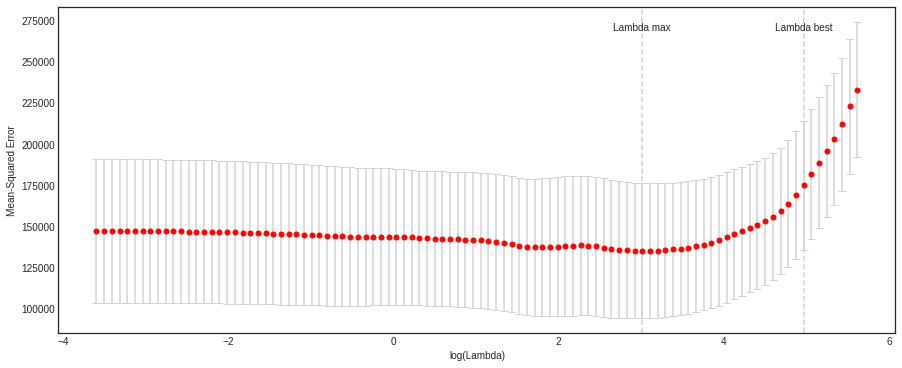

In [80]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(lasso3.lambda_path_), -lasso3.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=lasso3.cv_standard_error_, ecolor='lightgrey', capsize=4)

for ref, txt in zip([lasso3.lambda_best_, lasso3.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [81]:
pred = lasso3.predict(X_test, lamb=lasso3.lambda_max_)
mean_squared_error(y_test, pred)

104666.04215104156

#### Fit model on full dataset

In [82]:
lasso4 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error', n_splits=10)
lasso4.fit(X, y)

ElasticNet(alpha=1, cut_point=1.0, fit_intercept=True,
           lambda_path=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.5793322...
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
           lower_limits=-inf, max_features=None, max_iter=100000,
           min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100, n_splits=10,
           random_state=None, scoring='mean_squared_error', standardize=True,
           tol=1e-07, upper_limits=inf, verbose=False)

In [83]:
# These are not really close to the ones in the book.
pd.Series(lasso4.coef_path_[:,lasso4.lambda_max_inx_], index=X.columns)

AtBat           -1.560098
Hits             5.693168
HmRun            0.000000
Runs             0.000000
RBI              0.000000
Walks            4.750540
Years           -9.518024
CAtBat           0.000000
CHits            0.000000
CHmRun           0.519161
CRuns            0.660407
CRBI             0.391541
CWalks          -0.532687
PutOuts          0.272620
Assists          0.174816
Errors          -2.056721
League_N        32.109569
Division_W    -119.258342
NewLeague_N      0.000000
dtype: float64

# Lab 3

### 6.7.1 Principal Components Regression

Scikit-klearn does not have an implementation of PCA and regression combined like the 'pls' package in R.
https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf

In [84]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

(19, 19)


,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


The above loadings are the same as in R.

In [85]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(263, 19)


,0,1,2,3,4,5
0,-0.009649,1.870522,1.265145,-0.935481,1.109636,1.211972
1,0.411434,-2.429422,-0.909193,-0.264212,1.232031,1.826617
2,3.466822,0.825947,0.555469,-1.616726,-0.857488,-1.028712
3,-2.558317,-0.230984,0.519642,-2.176251,-0.820301,1.491696
4,1.027702,-1.573537,1.331382,3.494004,0.983427,0.513675


The above principal components are the same as in R.

In [86]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

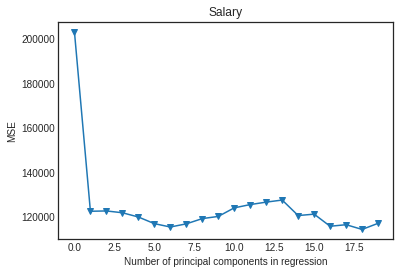

In [87]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 18 components.

In [88]:
regr_test = LinearRegression()
regr_test.fit(X_reduced, y)
regr_test.coef_

array([ 106.36859204,  -21.60350456,   24.2942534 ,  -36.9858579 ,
        -58.41402748,   62.20632652,   24.63862038,   15.82817701,
         29.57680773,   99.64801199,  -30.11209105,   20.99269291,
         72.40210574, -276.68551696,  -74.17098665,  422.72580227,
       -347.05662353, -561.59691587,  -83.25441536])

#### Fitting PCA with training data

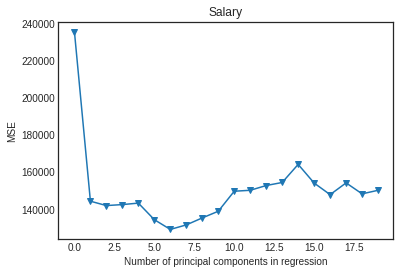

In [89]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 6 components.

#### Transform test data with PCA loadings and fit regression on 6 principal components

In [90]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

111994.42273636989

### 6.7.2 Partial Least Squares

Scikit-learn PLSRegression gives same results as the pls package in R when using 'method='oscorespls'. In the LAB excercise, the standard method is used which is 'kernelpls'. 

When doing a slightly different fitting in R, the result is close to the one obtained using scikit-learn.

    pls.fit=plsr(Salary~., data=Hitters, subset=train, scale=TRUE, validation="CV", method='oscorespls')
    validationplot(pls.fit,val.type="MSEP", intercept = FALSE)
   
See documentation:
http://scikit-learn.org/dev/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression

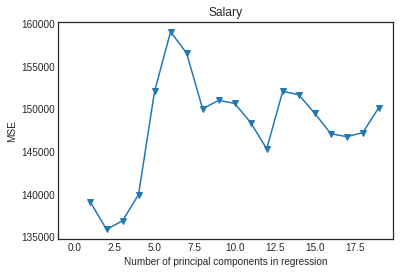

In [91]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [92]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

104838.51042760801